In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
    Created on Tue Apr 2 2024
    
    @author: Yaning
"""

import math
import os
# from turtle import position
import torch
import torch.distributions.constraints as constraints
import pyro
from pyro.optim import Adam
from pyro.infer import SVI, Trace_ELBO, Predictive
import pyro.distributions as dist
from tqdm import tqdm
import matplotlib.pyplot as plt
from statistics import mean 
# import pandas as pd
import numpy as np
import scipy.stats as stats
import pandas as pd
import pickle

np.set_printoptions(threshold=np.inf)

/home/yaning/Documents/python_envs/spike/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
with open('/home/yaning/Documents/Discounting/results/array_cafe_gamble.pkl', 'rb') as f:
    data = pickle.load(f)

In [3]:
data.shape

(2, 30, 170, 8)

In [4]:
delay_list = np.unique(data[:,:,:,2])

In [5]:
delay_list = np.round(delay_list)

In [6]:
delay_list = np.unique(delay_list)

In [5]:
len(delay_list)

20

In [6]:
delay_list

array([ 0.1,  0.2,  0.3,  0.4,  0.6,  0.7,  1.3,  1.4,  2.3,  2.4,  2.9,
        3.2,  4.5,  5. ,  5.8,  6.2,  7.3,  7.5, 11.8, 12.2])

In [7]:
data_rearranged = [[] for _ in range(len(delay_list))]

In [8]:
test = data.reshape(10200,8)
# test = data.reshape(7080,6)
# test = data.reshape(53040, 5)

In [9]:
for i in range(len(delay_list)):
    for j in test:
        if j[2] == delay_list[i]:
            data_rearranged[i].append(j)

In [96]:
# special round up with the future cue dataset
for i in range(len(delay_list)):
    for j in test:
        if np.around(j[2]) == delay_list[i]:
            data_rearranged[i].append(j)

In [97]:
lengths = []
for i in data_rearranged:
    lengths.append(len(i))

max_len = max(lengths)

In [98]:
for i in range(len(data_rearranged)):
    if len(data_rearranged[i]) != max_len:
        new_array = np.tile(data_rearranged[i], ((max_len // len(data_rearranged[i]) + 1), 1))[:max_len]
        print(len(new_array))
        data_rearranged[i] = new_array

1091
1091
1091
1091
1091
1091
1091
1091
1091
1091
1091
1091
1091
1091
1091
1091
1091
1091
1091
1091
1091
1091
1091


In [202]:
len(data_rearranged[10])

1091

In [111]:
truncated_arrays = [arr[:min(lengths)] for arr in data_rearranged]

(array([8., 7., 3., 3., 0., 0., 0., 1., 1., 1.]),
 array([  48. ,  152.3,  256.6,  360.9,  465.2,  569.5,  673.8,  778.1,
         882.4,  986.7, 1091. ]),
 <BarContainer object of 10 artists>)

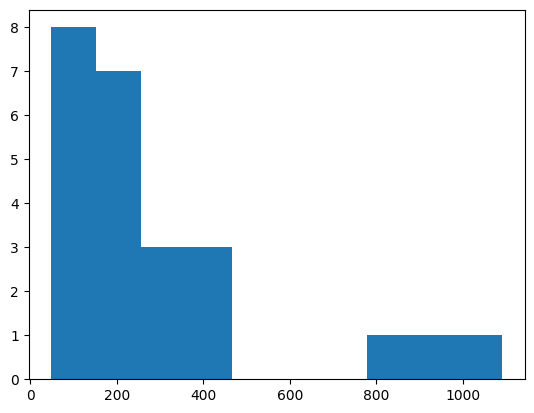

In [149]:
plt.hist(lengths)

In [151]:
truncated_arrays.shape

torch.Size([24, 48, 6])

In [10]:
data_rearranged = np.array(data_rearranged)

In [113]:
truncated_arrays = np.array(truncated_arrays)

In [117]:
truncated_arrays = torch.tensor(truncated_arrays)

In [152]:
data_rearranged = truncated_arrays

In [11]:
data_rearranged = torch.tensor(data_rearranged)

In [13]:
data_rearranged.shape

torch.Size([20, 510, 8])

In [31]:
real_data = data_rearranged

In [17]:
trial_num = data.shape[-2]
info_num = data.shape[-1]

real_data = data.reshape(60,trial_num,info_num)

In [18]:
real_data = torch.tensor(real_data)

In [14]:
# np.random.seed(123)
# torch.manual_seed(123)

# beta_variance = lambda alpha, beta: alpha*beta / ((alpha+beta)**2 * (alpha + beta + 1))
# gamma_variance = lambda conc, rate: conc/(rate**2)

# device = torch.device("cpu")

# torch.set_default_tensor_type(torch.DoubleTensor)


def model(data):
    # in the order of mean_u, sigma_u, sigma_es, beta
    num_params = 2
    num_agents = data.shape[0]
    num_trials = data.shape[1]
    # define hyper priors over model parameters
    # prior over sigma of a Gaussian is a Gamma distribution
    a = pyro.param('a', torch.ones(num_params), constraint=dist.constraints.positive)
    lam = pyro.param('lam', torch.ones(num_params), constraint=dist.constraints.positive)
    tau = pyro.sample('tau', dist.Gamma(a, a/lam).to_event(1)) # mean = a / (a/lam) = lam

    sig = pyro.deterministic('sig', 1/torch.sqrt(tau)) # Gauss sigma

    # each model parameter has a hyperprior defining group level mean
    # in the form of a Normal distribution
    m = pyro.param('m', torch.zeros(num_params))
    s = pyro.param('s', torch.ones(num_params), constraint=dist.constraints.positive)
    mu = pyro.sample('mu', dist.Normal(m, s*sig).to_event(1)) # Gauss mu, wieso s*sig?

    # in order to implement groups, where each subject is independent of the others, pyro uses so-called plates.
    # you embed what should be done for each subject into the "with pyro.plate" context
    # the plate vectorizes subjects and adds an additional dimension onto all arrays/tensors
    # i.e. p1 below will have the length num_agents
    with pyro.plate('ag_idx', num_agents):
        # draw parameters from Normal and transform (for numeric trick reasons)
        base_dist = dist.Normal(0., 1.).expand_by([num_params]).to_event(1)
        # Transform via the pointwise affine mapping y = loc + scale*x (-> Neal's funnel)
        transform = dist.transforms.AffineTransform(mu, sig) 
        locs = pyro.sample('locs', dist.TransformedDistribution(base_dist, [transform]))

    group_indices = torch.arange(num_agents).unsqueeze(1).repeat(1, num_trials).reshape(-1)
    

    with pyro.plate('data', num_agents*num_trials):
        # mean_u = torch.exp(locs[:,0])[group_indices]
        # sigma_u = torch.exp(locs[:,1])[group_indices]
        sigma_rate = torch.exp(locs[:,0])[group_indices]
        beta = torch.exp(locs[:,1])[group_indices]

        # e_mean = (mean_u*sigma_rate**2 +
        #          data[:,:,3].view(-1))/(1 + sigma_rate**2)
        e_mean = (data[:,:,3].view(-1))/(1 + sigma_rate**2)
        # e_sigma = ((sigma_rate**2)/(sigma_rate**2 + 1))**0.5

        # e_dist  = dist.Normal(e_mean, e_sigma)
        # pos = 1 - e_dist.cdf(torch.tensor(20.))
        # softmax_args = torch.stack([beta*pos, beta*(1-pos)])
        sum = e_mean + torch.tensor(20.)
        softmax_args = torch.stack([beta*e_mean/sum, beta*torch.tensor(20.)/sum])
        p = torch.softmax(softmax_args, dim = 0)[0]
        pyro.sample("obs", dist.Bernoulli(probs = p), obs=data[:,:,4].view(-1))
    # return locs
            

In [15]:
def guide(data):
    num_params = 2
    num_agents = data.shape[0]
    # biject_to(constraint) looks up a bijective Transform from constraints.real 
    # to the given constraint. The returned transform is guaranteed to have 
    # .bijective = True and should implement .log_abs_det_jacobian().
    trns = torch.distributions.biject_to(dist.constraints.positive)

    # define mean vector and covariance matrix of multivariate normal
    m_hyp = pyro.param('m_hyp', torch.zeros(2*num_params))
    st_hyp = pyro.param('scale_tril_hyp',
                    torch.eye(2*num_params),
                    constraint=dist.constraints.lower_cholesky)

    # set hyperprior to be multivariate normal
    # scale_tril (Tensor) – lower-triangular factor of covariance, with positive-valued diagonal
    hyp = pyro.sample('hyp',
                    dist.MultivariateNormal(m_hyp, scale_tril=st_hyp),
                    infer={'is_auxiliary': True})

    # mu & tau unconstrained
    unc_mu = hyp[..., :num_params]
    unc_tau = hyp[..., num_params:]

    # constrained tau, shape num_params, or num_particles, 1, num_params
    c_tau = trns(unc_tau)

    # ld = log_density
    # log_abs_det_jacobian(x, y) computes derivative |dy/dx|
    ld_tau = -trns.inv.log_abs_det_jacobian(c_tau, unc_tau)
    
    # sum_rightmost(x, dim)
    # sum out ``dim`` many rightmost dimensions of a given tensor.
    # ld_tau.shape is num_params, or num_particles, 1, num_params before sum_rightmost
    ld_tau = dist.util.sum_rightmost(ld_tau, ld_tau.dim() - c_tau.dim() + 1)

    # some numerics tricks
    mu = pyro.sample("mu", dist.Delta(unc_mu, event_dim=1))
    # c_tau shape: num_params, or num_particles, 1, num_params
    # ld_tau shape: [] or num_particles, 1,
    tau = pyro.sample("tau", dist.Delta(c_tau, log_density=ld_tau, event_dim=1))

    m_locs = pyro.param('m_locs', torch.zeros(num_agents, num_params))
    st_locs = pyro.param('scale_tril_locs',
                    torch.eye(num_params).repeat(num_agents, 1, 1),
                    constraint=dist.constraints.lower_cholesky)
    
    with pyro.plate('ag_idx', num_agents):
        locs = pyro.sample("locs", dist.MultivariateNormal(m_locs, scale_tril=st_locs))

    return {'tau': tau, 'mu': mu, 'locs': locs, 'm_locs': m_locs, 'st_locs': st_locs}

In [ ]:
pyro.render_model(model, model_args=(real_data,), render_params=True, render_distributions=True)

Mean ELBO 4904.95: 100%|███████████████████████████████████████████████████████████████| 4000/4000 [00:14<00:00, 283.74it/s]


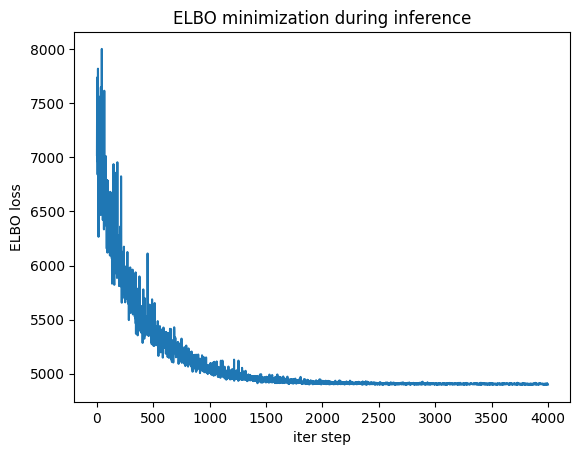

In [16]:
# this is for running the notebook in our testing framework
smoke_test = ('CI' in os.environ)
# the step was 2000
n_steps = 2 if smoke_test else 4000

# assert pyro.__version__.startswith('1.8.6')

# clear the param store in case we're in a REPL
pyro.clear_param_store()# setup the optimizer
# the learning rate was 0.0005 , "betas": (0.90, 0.999)
# tried "n_par":15 in adam params but it does not have this argument
adam_params = {"lr": 0.01}
optimizer = Adam(adam_params)
# setup the inference algorithm
svi = SVI(model, guide, optimizer, loss=Trace_ELBO())
# svi = SVI(model_gamma, guide_gamma, optimizer, loss=Trace_ELBO())

loss = []
pbar = tqdm(range(n_steps), position = 0)
# do gradient steps
for step in pbar:
    loss.append(torch.tensor(svi.step(data_rearranged)))
    pbar.set_description("Mean ELBO %6.2f" % torch.tensor(loss[-20:]).mean())
    # for name, value in pyro.get_param_store().items():
    #     print(name, pyro.param(name))
    if torch.isnan(loss[-1]):
	    break

plt.figure()
plt.plot(loss)
plt.xlabel("iter step")
plt.ylabel("ELBO loss")
plt.title("ELBO minimization during inference")
plt.show()

In [17]:
pos_dict = {}
for name, value in pyro.get_param_store().items():
    pos_dict[name] = value

# change the dictionary to numpy instead of tensor
# because somehow the tensor cannot be save with pickle
numpy_dict = {key: value.detach().numpy() for key, value in pos_dict.items()}

In [18]:
results = pyro.get_param_store()['m_locs']

In [17]:
delay_list

array([ 0.1,  0.2,  0.3,  0.4,  0.6,  0.7,  1.3,  1.4,  2.3,  2.4,  2.9,
        3.2,  4.5,  5. ,  5.8,  6.2,  7.3,  7.5, 11.8, 12.2])

In [17]:
# save the dictionary
with open('/home/yaning/Documents/Discounting/results/group_by_delay_cafe_gamble_two_params.pkl', 'wb') as f:
    pickle.dump(numpy_dict, f)

In [18]:
df = pd.DataFrame(numpy_dict["m_locs"], columns=["sigma_rate", "beta"])

In [19]:
df.to_csv("/home/yaning/Documents/Discounting/results/group_by_delay_cafe_gamble_two_params.csv", index=False)

In [20]:
results = results.detach().numpy()

In [21]:
results.shape

(20, 2)

In [29]:
for i in results[:,0]:
    print(i)

-0.94263357
-0.5740304
-0.51131415
-0.34070566
-0.18268113
-0.08184999
0.25877732
0.16297172
0.3782437
0.56121457
0.40068728
0.5635314
0.6389873
0.5327526
0.72688335
0.5858913
0.6734067
0.697494
0.72481894
0.83025676


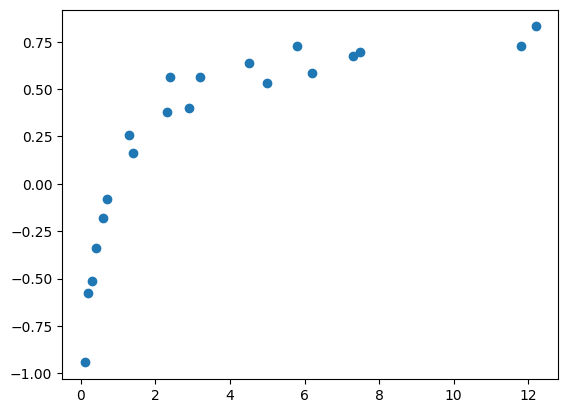

In [24]:
plt.scatter(delay_list, results[:,0])
# plt.savefig("/home/yaning/Documents/Discounting/results/images/group_by_delay_future_two_params.png")